<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/MaNGA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

In [1]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet

     |████████████████████████████████| 414 kB 5.2 MB/s 
     |████████████████████████████████| 40 kB 4.9 MB/s 
     |████████████████████████████████| 284 kB 50.1 MB/s 
     |████████████████████████████████| 351 kB 47.4 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 42.9 MB/s 
     |████████████████████████████████| 525 kB 66.3 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 67 kB 1.2 MB/s 
     |████████████████████████████████| 1.3 MB 46.3 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 
     |████████████████████████████████| 166 kB 52.5 MB/s 
     |████████████████████████████████| 215 kB 50.3 MB/s 
     |████████████████████████████████| 41 kB 280 kB/s 
     |████████████████████████

In [2]:
!pip install pafit --quiet

In [3]:
!git clone https://github.com/Jack3690/Kugelblitz

Cloning into 'Kugelblitz'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 447 (delta 55), reused 9 (delta 9), pack-reused 358
Receiving objects: 100% (447/447), 139.91 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [4]:
cd /content/Kugelblitz/

/content/Kugelblitz


In [5]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [6]:
!cp -a sas/map.py /usr/local/lib/python3.7/dist-packages/marvin/utils/plot/

# **Imports**

In [7]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso
import os
import json

from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table, join
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from photutils import aperture as aper 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.table import Table
from astropy.wcs import WCS

from pafit import fit_kinematic_pa as paf

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']=15

sb.set_style('dark')

/usr/local/lib/python3.7/dist-packages/marvin/core/exceptions.py:51: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  UserWarning)
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /root/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /root/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: Passing field metadata as keyword arguments is deprecated. Use the explicit `metadata=...` argument instead. Additional metadata: {'location': 'view_args'} (RemovedInMarshmallow4Warning)
[WARNING]: The 'missing' argument to fields is deprecated. Use 'load_default' instead. (RemovedInMarshmallow4Warning)


In [8]:
from marvin import config
# set the release 
config.setRelease("DR17")

[WARNING]: path /root/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /root/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [9]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.
 
    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size   = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if np.max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix,self.layers))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

# **Data**

## **Star Forming S0 Bar in DR17**

In [10]:
df = pd.read_csv('data/MaNGA_DR17_barred.csv')

with open('data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [11]:
os.system('wget https://data.sdss.org/sas/dr17/env/MANGA_PHOTO/pymorph/1.1.1/manga-pymorph-DR17.fits')

0

In [12]:
tab = Table.read('manga-pymorph-DR17.fits')

[WARNING]: hdu= was not specified but multiple tables are present, reading in first available table (hdu=1) (AstropyUserWarning)


In [35]:
ids = ['8083-3702','*8453-3704',
'*8551-9102', '8553-12705','8600-1901',
'8999-6101','12075-12703','*10215-3704',
'*9889-1901','9181-9101','*9049-3704',
'9488-6101','*7965-1901'] # SFB
len(ids)

13

In [36]:
SFB = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFB = SFB.append(df[df.plateifu==id])

In [37]:
SFB_py = tab[0:0].to_pandas()
m = []
for id in SFB.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFB_py = SFB_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFB_py['mangaid'] = m
SFB_py = SFB_py.drop(columns = ['MANGA_ID'])

In [38]:
SFB_py[['PLATEIFU','N_SE_BULGE']]

,PLATEIFU,N_SE_BULGE
0,b'8083-3702',1.1489
0,b'8453-3704',0.9620
0,b'8551-9102',0.7470
0,b'8553-12705',-999.0000
0,b'8600-1901',1.0595
0,b'8999-6101',0.1000
0,b'12075-12703',3.6006
0,b'10215-3704',1.5915
0,b'9889-1901',0.7122
0,b'9181-9101',0.9730


In [17]:
ids = ['8131-9102','8138-6102','8315-9102','10498-6104','*10217-6103','*9490-3701'] # SFB Edge

In [18]:
SFBe = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBe = SFBe.append(df[df.plateifu==id])

In [19]:
SFBe_py = tab[0:0].to_pandas()
m = []
for id in SFBe.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBe_py = SFBe_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBe_py['mangaid'] = m
SFBe_py = SFBe_py.drop(columns = ['MANGA_ID'])

In [20]:
SFBe_py[['PLATEIFU','A_HL_SE_BULGE']]

,PLATEIFU,A_HL_SE_BULGE
0,b'8131-9102',4.891012
0,b'8138-6102',5.991772
0,b'8315-9102',8.391121
0,b'10498-6104',3.180197
0,b'10217-6103',2.722085
0,b'9490-3701',1.320383


In [21]:
ids = ['7972-12703','8595-6104','*8611-3702','8625-3703','12620-9102',
       '12075-6101','11952-12703','11014-12705','9869-9102','8932-6104'] # SFBulge

In [22]:
SFBu = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBu = SFBu.append(df[df.plateifu==id])

In [23]:
SFBu_py = tab[0:0].to_pandas()
m = []
for id in SFBu.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBu_py = SFBu_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBu_py['mangaid'] = m
SFBu_py = SFBu_py.drop(columns = ['MANGA_ID'])

In [24]:
SFBu_py[['PLATEIFU','A_HL_SE_BULGE']]

,PLATEIFU,A_HL_SE_BULGE
0,b'7972-12703',0.257360
0,b'8595-6104',-999.000000
0,b'8611-3702',1.487027
0,b'8625-3703',3.516963
0,b'12620-9102',0.553846
0,b'12075-6101',3.612255
0,b'11952-12703',1.201920
0,b'11014-12705',7.762907
0,b'9869-9102',1.304501
0,b'8932-6104',3.621420


In [25]:
df_S0 = pd.merge(df_kurk,SFB_py, on = 'mangaid')

In [26]:
df_S0.keys()

Index(['SDSS_dr8objid', 'plateifu', 'mangaid', 'logMass', 'Bar/Ti', 'B/Ti',
       'u-r-disc', 'u-r-bar', 'u-r-bulge', 'g-i-disc', 'g-i-bar', 'g-i-bulge',
       'n-disc', 're-disc', 'ba-disc', 'n-bar', 're-bar', 'ba-bar', 'n-bulge',
       're-bulge', 'ba-bulge', 'INTID', 'PLATEIFU', 'OBJID', 'RA', 'DEC', 'Z',
       'EXTINCTION', 'DUPL_GR', 'DUPL_N', 'DUPL_ID', 'FLAG_FIT',
       'FLAG_FAILED_S', 'M_S', 'M_S_ERR', 'M_S_TRUNC', 'A_HL_S', 'A_HL_S_ERR',
       'A_HL_S_TRUNC', 'N_S', 'N_S_ERR', 'BA_S', 'BA_S_ERR', 'PA_S',
       'PA_S_ERR', 'GALSKY_S', 'FLAG_FAILED_SE', 'M_SE', 'M_SE_TRUNC',
       'A_HL_SE', 'A_HL_SE_TRUNC', 'BA_SE', 'BT_SE', 'BT_SE_TRUNC',
       'M_SE_BULGE', 'M_SE_BULGE_ERR', 'M_SE_BULGE_TRUNC', 'A_HL_SE_BULGE',
       'A_HL_SE_BULGE_ERR', 'A_HL_SE_BULGE_TRUNC', 'N_SE_BULGE',
       'N_SE_BULGE_ERR', 'BA_SE_BULGE', 'BA_SE_BULGE_ERR', 'PA_SE_BULGE',
       'PA_SE_BULGE_ERR', 'M_SE_DISK', 'M_SE_DISK_ERR', 'M_SE_DISK_TRUNC',
       'A_HL_SE_DISK', 'A_HL_SE_DISK_ERR', 'A

In [27]:
df_S0[df_S0['A_HL_SE_BULGE']>1]

,SDSS_dr8objid,plateifu,mangaid,logMass,Bar/Ti,B/Ti,u-r-disc,u-r-bar,u-r-bulge,g-i-disc,...,A_HL_SE_DISK_ERR,A_HL_SE_DISK_TRUNC,N_SE_DISK,N_SE_DISK_ERR,BA_SE_DISK,BA_SE_DISK_ERR,PA_SE_DISK,PA_SE_DISK_ERR,GALSKY_SE,SPA
0,1237657595686355278,10215-3704,1-153589,10.85,0.16,0.18,2.49,2.98,2.04,1.14,...,0.061855,3.498896,1.0,0.0,0.8993,0.0120,1.499700,4.0266,21.958164,42.112999
2,1237659330313191456,8600-1901,1-633729,10.11,0.43,0.00,1.92,1.33,0.00,0.86,...,0.041198,4.595543,1.0,0.0,0.7551,0.0047,-21.613100,1.0860,21.813921,137.335999
3,1237664837535596939,9495-3703,1-383698,10.38,0.41,0.00,2.13,1.95,0.00,0.91,...,0.056074,3.060630,1.0,0.0,0.5213,0.0057,28.455099,0.5659,21.835104,58.130001
4,1237662697572466956,9889-1901,1-375609,10.05,0.20,0.32,1.58,1.87,1.63,0.58,...,0.047678,2.821307,1.0,0.0,0.6397,0.0052,77.716003,0.5793,22.229946,117.972000


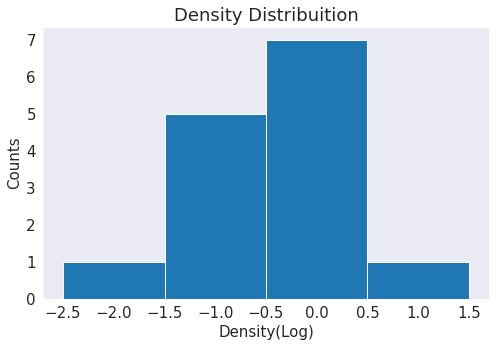

In [28]:
df_d = pd.read_csv('data/SB0_SFB_densities.csv').rename(columns = {'z_1':'z'})
plt.figure(figsize=(8,5))

data = df_d.density
bins = np.arange(-2.5,2,1)

plt.hist(data,bins)
plt.xlabel('Density(Log)')
plt.ylabel('Counts')
plt.title('Density Distribuition');

In [29]:
with open('data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [30]:
df_kurk

,SDSS_dr8objid,plateifu,mangaid,logMass,Bar/Ti,B/Ti,u-r-disc,u-r-bar,u-r-bulge,g-i-disc,...,g-i-bulge,n-disc,re-disc,ba-disc,n-bar,re-bar,ba-bar,n-bulge,re-bulge,ba-bulge
0,1237651272963326121,10001-1902,1-48201,10.44,0.13,0.31,2.65,2.27,2.65,1.21,...,1.19,1.0,20.70,0.80,0.62,9.10,0.33,0.95,2.37,0.87
1,1237651273500327989,10001-6103,1-48208,10.86,0.17,0.20,2.25,2.82,2.70,1.15,...,1.25,1.0,27.88,0.89,0.34,10.18,0.56,1.03,1.85,0.95
2,1237657595686355278,10215-3704,1-153589,10.85,0.16,0.18,2.49,2.98,2.04,1.14,...,1.21,1.0,14.50,0.84,0.45,5.76,0.42,0.89,1.62,0.88
3,1237664874576937381,10216-6101,1-412105,10.76,0.21,0.12,2.28,2.15,2.19,1.05,...,1.04,1.0,22.00,0.75,0.56,8.45,0.53,0.91,1.39,0.83
4,1237664835384771068,10217-6103,1-412058,10.42,0.27,0.13,2.14,1.85,1.28,0.96,...,0.91,1.0,13.39,0.92,0.30,9.62,0.32,0.12,0.82,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1237667323797962933,9876-3704,1-457163,10.14,0.10,0.31,2.31,2.33,2.47,1.02,...,1.12,1.0,18.65,0.86,0.10,14.34,0.25,2.42,6.02,0.53
121,1237667444585201702,9877-12701,1-623330,10.30,0.06,0.56,2.28,2.47,2.46,1.02,...,1.16,1.0,24.18,0.85,0.11,11.72,0.29,3.34,5.05,0.80
122,1237665531171373201,9881-3703,1-458301,10.43,0.14,0.16,2.17,2.75,2.61,1.04,...,1.38,1.0,15.41,0.69,0.41,6.43,0.40,1.05,1.47,0.80
123,1237655474509382051,9883-3703,1-176928,10.58,0.17,0.31,3.04,2.29,2.65,1.24,...,1.24,1.0,22.47,0.85,0.51,13.45,0.28,1.08,2.83,0.74


In [31]:
df_out = pd.merge(df,df_kurk,on = 'mangaid')
df_out

,plateifu_x,mangaid,objra,objdec,VI_morph,DR,SDSS_dr8objid,plateifu_y,logMass,Bar/Ti,...,g-i-bulge,n-disc,re-disc,ba-disc,n-bar,re-bar,ba-bar,n-bulge,re-bulge,ba-bulge
0,10001-1902,1-48201,134.193923,56.786747,S0,16,1237651272963326121,10001-1902,10.44,0.13,...,1.19,1.0,20.70,0.80,0.62,9.10,0.33,0.95,2.37,0.87
1,10001-6103,1-48208,134.008123,57.390964,S0,16,1237651273500327989,10001-6103,10.86,0.17,...,1.25,1.0,27.88,0.89,0.34,10.18,0.56,1.03,1.85,0.95
2,7957-1901,1-634477,255.895284,36.401536,S0,16,1237655504034201663,7957-1901,9.96,0.09,...,1.22,1.0,25.55,0.40,0.20,7.64,0.48,2.25,4.22,0.81
3,7964-6103,1-179135,315.474939,-0.304685,S0,16,1237663457238844107,7964-6103,10.41,0.36,...,0.00,1.0,14.09,0.90,2.07,3.50,0.53,0.00,0.00,0.00
4,8133-3701,1-377686,112.079253,43.302118,S0,16,1237663917335183755,8133-3701,10.25,0.21,...,1.76,1.0,9.49,0.72,0.44,5.91,0.36,0.30,0.95,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,9504-3704,1-164244,123.371658,29.037198,S0,17,1237658191609528484,9504-3704,10.49,0.34,...,0.96,1.0,15.31,0.90,0.34,6.82,0.51,0.35,1.20,0.94
115,9862-12701,1-455941,193.192823,27.906805,S0,17,1237667444048003160,9862-12701,9.81,0.20,...,1.14,1.0,16.49,0.84,0.36,10.26,0.34,1.22,2.49,0.82
116,9874-6101,1-456952,195.078300,27.937101,S0,17,1237667444048723991,9874-6101,9.70,0.29,...,0.00,1.0,16.51,0.95,1.62,7.61,0.27,0.00,0.00,0.00
117,9877-12701,1-623330,194.146629,28.275454,S0,17,1237667444585201702,9877-12701,10.30,0.06,...,1.16,1.0,24.18,0.85,0.11,11.72,0.29,3.34,5.05,0.80


In [32]:
df_out['pa_diff']= [-10.5,2.5,61.5,-20.5]

ValueError: ignored

In [ ]:
df_out

In [ ]:
plt.figure(figsize = (15,4))
plt.plot(df_out['g-i-bar'].values, abs(df_out['pa_diff'].values) ,'o');
plt.xlabel('g-i (bar)')
plt.ylabel('PA(diff) [degree]')
plt.title('Position angle VS bar colour')

In [ ]:
plt.figure(figsize = (15,4))
plt.plot(df_out['g-i-disc'].values, abs(df_out['pa_diff'].values) ,'o');
plt.xlabel('g-i (disc)')
plt.ylabel('PA(diff) [degree]')
plt.title('Position angle VS disc colour')

In [ ]:
plt.figure(figsize = (15,4))
plt.plot(df_out['g-i-bulge'].values, abs(df_out['pa_diff'].values) ,'o');
plt.xlabel('g-i (bulge)')
plt.ylabel('PA(diff) [degree]')
plt.title('Position angle VS bulge colour')

## **xGASS**

In [ ]:
ids = ['11014-12705', '11967-1901', '12083-12705', '12085-6103', '8150-6104', '8934-3701', '8934-6102', '8939-3701', '9195-6102', '9495-6101']

In [ ]:
len(ids)

10

In [ ]:
tab = Table.read('data/xGASS_MaNGA.fits')['plateifu','mangaid','RA', 'DEC', 'zSDSS', 
                                          'Dlum','lgMstar', 'expAB_r', 'model_r',
                                          'merr_r', 'ext_r', 'petrR50_r',
                                          'petrR90_r', 'petrR50_z', 'lgmust',
                                          'CINDX', 'INCL', 'NUVr', 
                                          'lgSFR_tot_median', 'SFR_best', 
                                          'SFRerr_best', 'SFRcase_best', 
                                          'zHI','W50cor', 'lgMHI', 'lgGF',
                                          'weight', 'Ngal_B', 'logMh_Mst_B',
                                          'lvir_ratB']
p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

df = tab.to_pandas()
df['plateifu'] = p

In [ ]:
tab_x = tab

In [ ]:
df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['plateifu']==i])

In [ ]:
def demo_con_style(ax, connectionstyle):
    x1, y1 = -2.5, -2.0
    x2, y2 =  -2.0, -2.5

    ax.plot([x1, x2], [y1, y2], ".",label='_nolegend_')
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )
    ax.text(-2.25,-2.25,s='1 dex', rotation = -45, fontsize = 20)

Text(0.5, 0.92, 'HI Scaling relation using NUV-r')

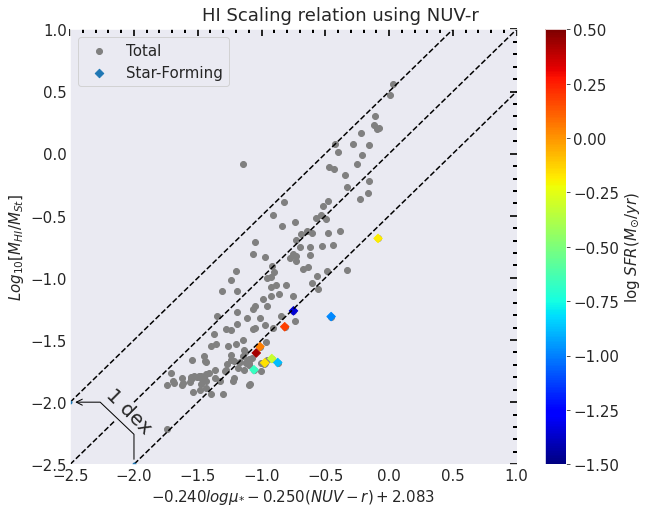

In [ ]:
fig, ax  = plt.subplots(figsize = (10,8))

M        = pow(10,tab['lgMstar'])
R50z     = tab['petrR50_z']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = tab['lgGF'] 
NUV_r    = tab['NUVr']
tab['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab['lgMH_Mst_pred']
y = lgMH_Mst

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_SF['lgMstar'])
R50z     = df_SF['petrR50_z']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = df_SF['lgGF'] 
NUV_r    = df_SF['NUVr']

df_SF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_SF['lgMH_Mst_pred']
y = lgMH_Mst

img = ax.scatter(x,y, marker = 'D', c = df_SF['lgSFR_tot_median'],cmap = 'jet',
                 vmin =-1.5,vmax=0.5,label = 'Star-Forming')
plt.colorbar(img,label = r"log $SFR(M_{\odot}/yr)$")
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
lgMH_Mst

16    -1.681
34    -1.604
41    -1.553
43    -1.393
110   -1.739
123   -0.682
124   -1.649
126   -1.683
137   -1.311
142   -1.265
Name: lgGF, dtype: float32

In [ ]:
df_SF[['plateifu','lgGF','lgMstar','lg_']]

,plateifu,lgGF,lgMstar
16,11014-12705,-1.681,9.807007
34,11967-1901,-1.604,10.569000
41,12083-12705,-1.553,10.556000
43,12085-6103,-1.393,10.405000
110,8150-6104,-1.739,10.611000
123,8934-3701,-0.682,9.118738
124,8934-6102,-1.649,9.926116
126,8939-3701,-1.683,10.120649
137,9195-6102,-1.311,9.249792
142,9495-6101,-1.265,9.366620


In [ ]:
df_SF.to_csv('xGASS_SF.csv')

In [ ]:
tab = Table.read('data/xGASS_MaNGA_HI.fits')[['PLATEIFU','MANGAID','OBJRA',
                                              'OBJDEC','zSDSS','Dlum','lgMstar',
                                              'NUVr','zHI','lgMHI','lgGF',
                                              'LOGMSTARS','LOGMHI','VHI','EV',
                                              'logMh_Mst_B','petrR50_z']]
tab.rename_column('PLATEIFU','plateifu')

p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

df_MHI = tab.to_pandas()
df_MHI['plateifu'] = p

No handles with labels found to put in legend.


Text(0.5, 0.92, 'HI Scaling relation using NUV-r')

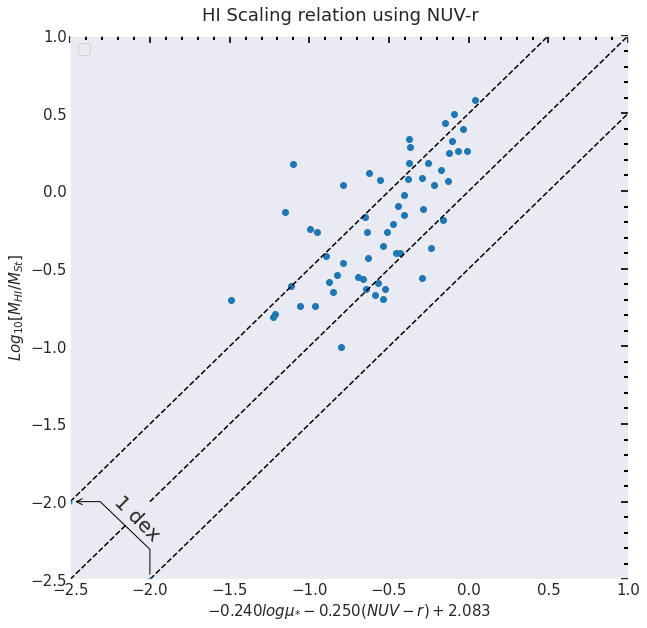

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,tab['LOGMSTARS'])
R50z     = tab['petrR50_z']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = tab['LOGMHI']-tab['LOGMSTARS'] 
NUV_r    = tab['NUVr']
tab['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab['lgMH_Mst_pred']
y = lgMH_Mst

img = ax.scatter(x,y)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
lgMH_Mst

0.2437114715576172
-1008.3239765167236
-0.1676626205444336
-1008.6669778823853
0.4352235794067383
0.13619709014892578
0.06170082092285156
0.588775634765625
-0.11323356628417969
-1009.1887149810791
-0.4162731170654297


In [ ]:
df_xGASS_MHI = pd.merge(df_SF,df_MHI, on = 'plateifu')

In [ ]:
df_xGASS_MHI

,plateifu,mangaid,RA,DEC,zSDSS_x,Dlum_x,lgMstar_x,expAB_r,model_r,merr_r,...,NUVr_y,zHI_y,lgMHI_y,lgGF_y,LOGMSTARS,LOGMHI,VHI,EV,logMh_Mst_B_y,petrR50_z_y
0,11014-12705,b'1-456339 ',194.47652,27.49064,0.016611,72.099998,9.807007,0.492382,15.006100,0.0031,...,4.82,0.000000,8.126,-1.681,9.535250,-999.0,-999.0,-999.0,0.0000,7.19
1,12083-12705,b'1-116725 ',344.36124,13.00165,0.025680,112.099998,10.556000,0.571026,14.464500,0.0026,...,4.54,0.025744,9.003,-1.553,10.149891,-999.0,-999.0,-999.0,13.1901,6.24
2,12085-6103,b'1-117014 ',345.92944,13.92654,0.027060,118.300003,10.405000,0.367157,14.967600,0.0026,...,3.44,0.027092,9.012,-1.393,10.193199,-999.0,-999.0,-999.0,11.9171,3.56
3,8150-6104,b'1-389509 ',147.53900,33.56933,0.027030,118.199997,10.611000,0.717678,14.275600,0.0021,...,4.46,0.000000,8.872,-1.739,10.217702,-999.0,-999.0,-999.0,12.1383,4.82
4,8934-3701,b'1-456772 ',194.02542,27.67811,0.016483,71.500000,9.118738,0.614720,15.131600,0.0029,...,1.69,0.016325,8.437,-0.682,9.046936,-999.0,-999.0,-999.0,0.0000,3.32
5,8934-6102,b'1-457009 ',196.04688,27.49044,0.017770,77.099998,9.926116,0.818161,14.990200,0.0027,...,4.57,0.000000,8.277,-1.649,9.561013,-999.0,-999.0,-999.0,0.0000,4.89
6,8939-3701,b'1-298715 ',125.36168,24.45309,0.019782,86.000000,10.120649,0.621241,14.740100,0.0024,...,4.41,0.000000,8.438,-1.683,9.799382,-999.0,-999.0,-999.0,0.0000,3.87
7,9195-6102,b'1-42704 ',27.65368,13.11023,0.016488,71.500000,9.249792,0.932624,16.097601,0.0046,...,3.40,0.016531,7.939,-1.311,9.255931,-999.0,-999.0,-999.0,13.0449,5.14
8,9495-6101,b'1-298482 ',122.55074,22.77229,0.015594,67.599998,9.366620,0.528212,15.977900,0.0038,...,4.38,0.015624,8.102,-1.265,9.247917,-999.0,-999.0,-999.0,0.0000,4.62


In [ ]:
df_xGASS_MHI.keys()

Index(['plateifu', 'mangaid', 'RA', 'DEC', 'zSDSS_x', 'Dlum_x', 'lgMstar_x',
       'expAB_r', 'model_r', 'merr_r', 'ext_r', 'petrR50_r', 'petrR90_r',
       'petrR50_z_x', 'lgmust', 'CINDX', 'INCL', 'NUVr_x', 'lgSFR_tot_median',
       'SFR_best', 'SFRerr_best', 'SFRcase_best', 'zHI_x', 'W50cor', 'lgMHI_x',
       'lgGF_x', 'weight', 'Ngal_B', 'logMh_Mst_B_x', 'lvir_ratB',
       'lgMH_Mst_pred', 'MANGAID', 'OBJRA', 'OBJDEC', 'zSDSS_y', 'Dlum_y',
       'lgMstar_y', 'NUVr_y', 'zHI_y', 'lgMHI_y', 'lgGF_y', 'LOGMSTARS',
       'LOGMHI', 'VHI', 'EV', 'logMh_Mst_B_y', 'petrR50_z_y'],
      dtype='object')

In [ ]:
M        = pow(10,df_xGASS_MHI['LOGMSTARS'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = df_xGASS_MHI['LOGMHI']-df_xGASS_MHI['LOGMSTARS'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x1 = df_xGASS_MHI['lgMH_Mst_pred'].values
y1 = lgMH_Mst.values

In [ ]:
lgMH_Mst

0   -1008.535250
1   -1009.149891
2   -1009.193199
3   -1009.217702
4   -1008.046936
5   -1008.561013
6   -1008.799382
7   -1008.255931
8   -1008.247917
dtype: float64

(-1.0096110926950794, -0.024266836859927338)

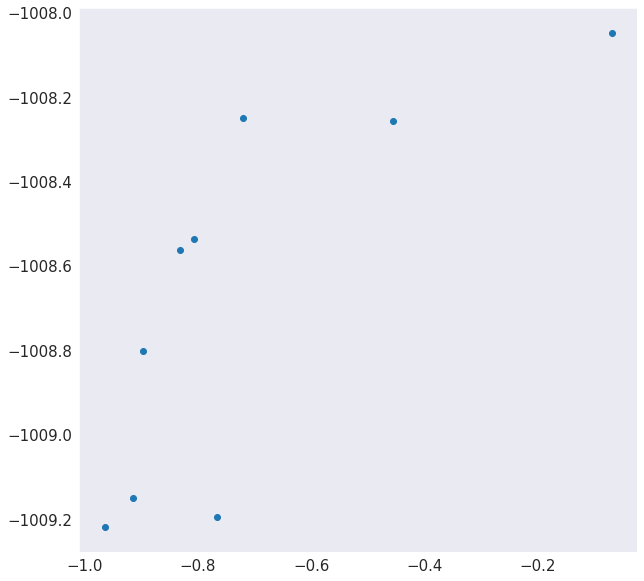

In [ ]:
plt.scatter(x1, y1)
plt.xlim()

In [ ]:
M        = pow(10,df_xGASS_MHI['lgMstar_x'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = df_xGASS_MHI['lgGF_x'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x2 = df_xGASS_MHI['lgMH_Mst_pred']
y2 = lgMH_Mst

(-2.5, 1.0)

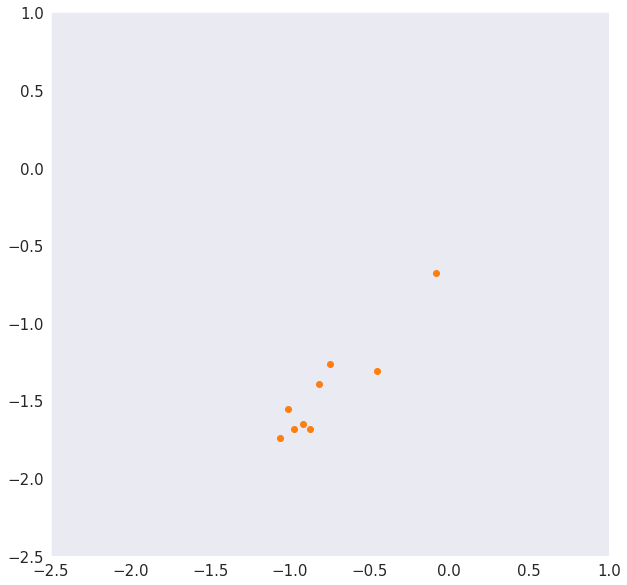

In [ ]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.ylim(-2.5,1)
plt.xlim(-2.5,1)

Text(0.5, 0.92, 'HI Scaling relation using NUV-r')

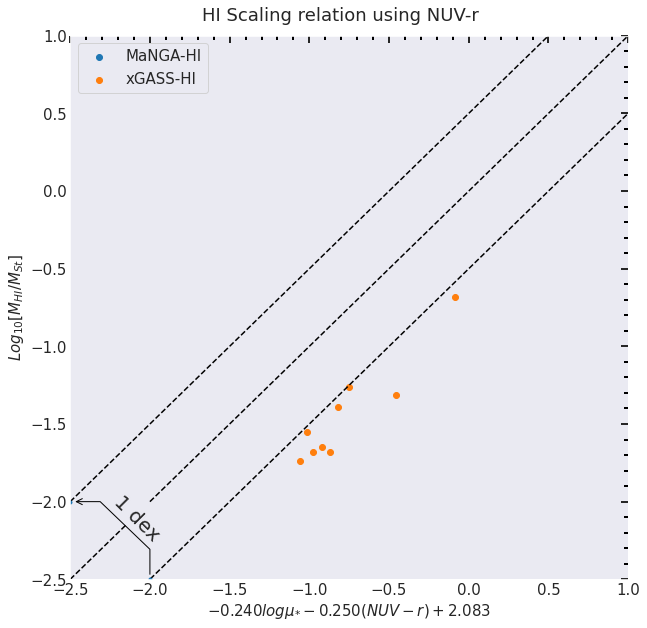

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

ax.scatter(x1,y1)
ax.scatter(x2,y2)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend(['MaNGA-HI','xGASS-HI'])
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

# **Saving to Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls

'ASI POSTER 2021'/                 'Motivation Letter HU.gdoc'
'Bangalore Days'/                  'Motivation Letter_INAF.gdoc'
'Colab Notebooks'/                 'Motivation Letter_NCBJ.gdoc'
'Cover Letter.gdoc'                 PRNU_level_output.fits
'Cover Letter Uppsala.gdoc'        'Research Experience.gdoc'
'Dr. Chrisphin Karthick'/          'SDR data recording code.py'
'Dusty Galaxies in MaNGA'/         'Star forming Bars in S0 Galaxies'/
 galfit.feedme                     'Untitled document.gdoc'
 Jovian/                            WIN_20190220_09_54_10_Pro.mp4
'jvf-vhzv-iqn - Jun 4, 2022.gjam'   xgass/
'Letter for UWA.gdoc'


Choose a location in your drive

In [ ]:
cd '/content/gdrive/MyDrive/Dusty Galaxies in MaNGA/Maps'

/content/gdrive/MyDrive/Dusty Galaxies in MaNGA/Maps


In [ ]:
ids = [i[:-9] for i in os.listdir()]
ids

['8143-6104',
 '8141-12703',
 '8610-12702',
 '8626-12701',
 '12491-6104',
 '10512-6102',
 '11742-9101',
 '9026-12701',
 '8615-3703',
 '8078-9102',
 '8081-9101',
 '10226-9102',
 '10223-9101',
 '8250-9102',
 '8252-3701',
 '8997-12702',
 '9499-9101',
 '8986-12702',
 '11830-3701',
 '8980-12703',
 '11020-9102',
 '9864-12704',
 '11940-12702',
 '9035-9101',
 '9036-9101',
 '11949-12704',
 '9498-9102',
 '11940-12704',
 '9088-6104',
 '9090-3704',
 '9044-9101',
 '9089-12703',
 '8943-6102',
 '12483-12701',
 '9879-12701',
 '8982-12704',
 '8614-3703',
 '8244-6102',
 '10844-1901',
 '8997-12704',
 '9193-12701',
 '8155-6101',
 '8082-6102',
 '10504-9101',
 '8441-12704',
 '8336-12701',
 '11979-12702']

# **Maps with Mapplot**

In [ ]:
def aperture_gen(models,angle_scale,len_scale, origin = 'center' , a_offset = 0):
  apertures = {}
  for i,model in enumerate(models):

    X_c = model[f'{i+1}_XC'].split('+')[0]
    if '*' in X_c:
      print('Error in X_c')
      X_c = float(X_c[1:-2])
    else:
      X_c = float(X_c)
    if origin == 'center':
      X_c-=64
    X_c*=(len_scale/128)

    Y_c = model[f'{i+1}_YC'].split('+')[0]
    if '*' in Y_c:
      print('Error in Y_c')
      Y_c = float(Y_c[1:-2])
    else:
      Y_c = float(Y_c)

    if origin == 'center':
      Y_c-=64
    Y_c*=(len_scale/128)

    PA = model[f'{i+1}_PA'].split('+')[0]
    if '*' in PA:
      print('Error in PA')
      PA = float(PA[1:-2])
    else:
      PA = float(PA)

    AR = model[f'{i+1}_AR'].split('+')[0]
    if '*' in AR:
      print('Error in AR')
      AR = float(AR[1:-2])
    else:
      AR = float(AR)


    if i<2:
      RE = model[f'{i+1}_RE'].split('+')[0]
      if '*' in RE:
        print('Error in X_c')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    else:
      RE = model[f'{i+1}_RS'].split('+')[0]
      if '*' in RE:
        print('Error in RS')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)
    RE*=(0.394/angle_scale)
    a = RE
    b = AR*a
    aperture = aper.EllipticalAperture((X_c,Y_c), a,b,
                                       theta = np.pi -(PA + a_offset)*np.pi/180)
    apertures[f'aper_{i+1}'] = aperture
  return apertures

In [ ]:
sf_s0= ['10215-3704']

In [ ]:
download = 0
format = 'png'
colors_ = ['black','red','purple']
models = ['Bulge','Bar','Disk']
for plateifu in sf_s0:

  maps = Maps(plateifu=plateifu)
  mangaid=maps.mangaid
  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image

  gs = gridspec.GridSpec(2,4) 
  fig=plt.figure(figsize=(35,16))

  optical = maps.getImage()
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

  # SDSS
  ax1 = fig.add_subplot(gs[0,0])
  ax1.grid(False)
  ax1.imshow(optical.data, extent = (-r,r,-r,r))
  ax1.grid(False)
  apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, origin = 'center')
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
  ax1.legend()
 
  # Legacy
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )
  ax1 = fig.add_subplot(gs[1,0])
  ax1.grid(False)
  ax1.imshow(img.image, extent = (-r,r,-r,r))
  ax1.grid(False)
  ax1.axis('off')
  optical.overlay_hexagon(ax1, color = 'red')
  # Crop Image to match IFU size
  optical.get_new_cutout(size,size)
  apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]


  # H-alpha 
  ax1 = fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_ha_6564
  ax1.grid(True,which='major')
  fig,ax1,cb=mapplot.plot(dapmap=ha,ax=ax1,fig=fig,return_cb=True)
  ax1.set_autoscale_on(False)
  cb.remove()
  cb=plt.colorbar(ax1.get_images()[1],ax=ax1,anchor=(0,5),shrink=0.86)
  ax1.set_xlabel('pos.eq.ra')
  ax1.set_ylabel('pos.eq.dec')

  height = 2*maps.wcs.to_header()['CRPIX1']
  apertures = aperture_gen(mods[:-1],scale, height)
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax1,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax1.legend()
  
 
  # H alpha EW
  ewha = maps['emline_sew_ha_6564']
  
  ax2 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))

  ax2.grid(True,which='major')
  fig,ax2,cb=mapplot.plot(dapmap=ewha,ax=ax2,fig=fig,return_cb=True)
  #ax2.set_autoscale_on(False)
  #ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb.remove()
  cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.86)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')

  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax2,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax2.legend()
  

  #------------------------------------------------------------------------------------------
  
  mask, fig_bpt, ax_bpt = maps.get_bpt(show_plot=False)

  # BPT Diagram

  SF = mask['sf']['global'].astype(np.float64)
  COMP = mask['comp']['global'].astype(np.float64)
  SEYF = mask['seyfert']['global'].astype(np.float64)
  LIN = mask['liner']['global'].astype(np.float64)
  AMB = mask['ambiguous']['global'].astype(np.float64)

  # Giving labels to each class

  SF   *= 5
  COMP *= 4
  SEYF *= 3
  LIN  *= 2
  AMB  *= 1

  # Sum the above masks
  bpt = SF + COMP + SEYF + LIN + AMB

  # Let's make a color map for BPT map

  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

  # IFU nocov mask
  ha = maps.emline_gew_ha_6564 # For getting pixmask

  nocov = ha.pixmask.get_mask('NOCOV')

  # Plot

  ax3 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))
  # Mapplot plot

  fig, ax3, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax3, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='BPT Diagram')

  ax3.set_autoscale_on(False)

  # Over plot optical contours with black color and given levels

  levels = [60., 90., 120., 150., 180., 210., 240.]

  # Get SDSS image 

  optical = maps.getImage()

  # Prepare for plotting contours

  # Set the size of image cutout

  scale = maps.wcs.to_header()['PC2_2']*3600  # Gives arcsec/ pixel

  size = 2*maps.wcs.to_header()['CRPIX1']*scale # Give angular size in arcseconds

  # Getting new cutout

  optical.get_new_cutout(width = size, height = size)

  filter_r = np.rot90(np.array(optical.data)[:,:,0].T )

  # Remove grid
  ax3.grid(False)

  # Plot contours and transform it with optical.wcs and assign the contours black color with levels = levels and zorder =11
  #ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  # Remove default colorbar
  cb.remove()
  # Generate new color bar
  cb = plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.86)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
  # Set x and y label
  #ax3.set_xlabel('pos.eq.ra')
  #ax3.set_ylabel('pos.eq.dec')

  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax3,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax3.legend()

  # WHAN
  nii = maps.emline_gflux_nii_6585  # Get emline gaussian flux of nii with wavelength 6585
  ha = maps.emline_gflux_ha_6564    # Get emline gaussian flux of H alpha  with wavelength 6564
  niiha = nii/ha

  ewha = maps['emline_sew_ha_6564']  # Get emline_sew of H alpha  with wavelength 6564
  ewnii = maps['emline_sew_nii_6585'] # Get emline_sew of nii with wavelength 6585

  # Take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # Create the WHAN categories. Hint : Use ewha.value, ewnii.value, and logniiha

  psf = (logniiha < -0.4) & (ewha.value > 3)                        # Pure Star Forming
  sagn = (logniiha > -0.4) & (ewha.value > 6)                       # Strong AGN
  wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))  # Weak AGN
  rg = ewha.value < 3                                               # Retired Galaxy  
  pg = (ewha.value < 0.5) & (ewnii.value < 0.5)                     # Passive Galaxy

  # Create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)

  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr  = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr       = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = 6

  #------------------------------------------------------------------------------------------

  # WHAN IFU

  ax4 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
  #  Remove grid
  ax4.grid(False)

  # Create colomap with colors 'red', 'blue', 'goldenrod', 'green', 'purple'
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])

  # Get nocov mask from ewha map

  nocov = ewha.pixmask.get_mask('NOCOV')

  # Complete the mapplot.plot  function call
  fig, ax4, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='WHAN Diagram')

  # Set autoscale to False
  ax4.set_autoscale_on(False)

  # Get SDSS optical image
  optical = maps.getImage()

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get new cutout with new size
  optical.get_new_cutout(size,size,size/512)

  # Slice the optical image and get r band data
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )

  # Assign levels [60.,  90., 120., 150., 180., 210., 240.]
  levels = [60.,  90., 120., 150., 180., 210., 240.]

  # Create contour of filter_r and transform it using optical.wcs. Give color = 'black' and zorder=11
  #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  # Remove default colorbar
  cb.remove()

  # Create new color bar
  cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.86)

  # Set ticks [1, 2, 3, 4, 5]
  cb.set_ticks([1, 2, 3, 4, 5])

  # Set ticklabels ['PSF', 'SAGN', 'WAGN', 'RG', 'PG']
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])

  # Set axes labels
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')

  apertures = aperture_gen(mods[:-1],scale, height)
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax4,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax4.legend()
  
  
  #------------------------------------------------------------------------------------------

  # Metallicity Map
  ax5 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  n2 = nii/ ha
  logn2 = np.log10(n2)
  oh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
  ax5.grid(True,which='major')
  fig,ax5,cb=mapplot.plot(dapmap=oh,mask=mask,ax=ax5,fig=fig,return_cb=True,cbrange=[8.65,8.9],title='Metallicity Map')
  #ax5.set_autoscale_on(False)
  #ax5.contour(filter_r, transform=ax5.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb.remove()
  cb=plt.colorbar(ax5.get_images()[1],ax=ax5,anchor=(0,5),shrink=0.82,label= '12+log(O/H)')
  ax5.set_xlabel('pos.eq.ra')
  ax5.set_ylabel('pos.eq.dec')

  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax5,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax5.legend()
  

    #------------------------------------------------------------------------------------------

  # DN 4000 with optical contours    
  ax6 = fig.add_subplot(gs[1,3],projection=maps.wcs,slices=('x','y',0))

  dn = maps.specindex_dn4000
  ax6.grid(True,which='major')
  fig,ax6,cb=mapplot.plot(dapmap=dn,ax=ax6,fig=fig,return_cb=True,cbrange=[1,2])
  #ax6.set_autoscale_on(False)
  #ax6.contour(filter_r, transform=ax6.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb.remove()
  cb=plt.colorbar(ax6.get_images()[1],ax=ax6,anchor=(0,5),shrink=0.82)
  ax6.set_xlabel('pos.eq.ra')
  ax6.set_ylabel('pos.eq.dec')

  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax6,color = colors_[k],
                             label = models[k], zorder = 101 )
  ax6.legend()
  

  fig.suptitle(f"PLATEIFU : {id} | MANGAID : {mangaid}",size=20,va='top',y=0.9)
  plt.subplots_adjust(left=0.1)
  if download:
    fig.savefig(f'{plateifu}maps',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------
  plt.pause(0.5)
  break

In [ ]:
optical = maps.getImage()

Text(0, 0.5, 'kpc')

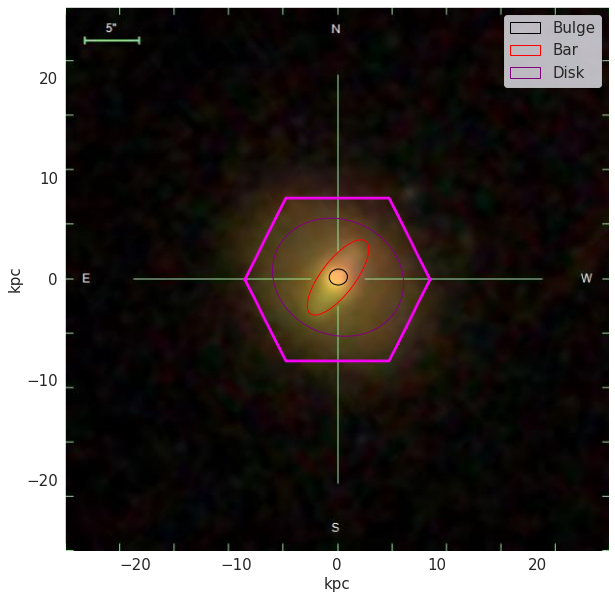

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

# **Maps with Matplotlib**

## **Utils**

In [ ]:
use_masks = ['NOCOV','LOWCOV','DEADFIBER','FORESTAR','NOVALUE','UNRELIABLE','MATHERROR','FITFAILED','NOCORRECTION','MULTICOMP','NEARBOUND','DONOTUSE']
def goodspax(dapmap,type=None):
  if type==None:
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = abs(dapmap.value*np.sqrt(dapmap.ivar))<1.0
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,np.nan,1)

  elif type=='vel':

    mask = np.where(dapmap.mask>0,1e-32,1)
   
  return dapmap.value*mask

In [ ]:
scale_s

0.08899999999992

## **Position Angle**

In [ ]:
for ifu1, ifu2 in dr16.reshape(-1,2):
  if not os.path.exists('pa'):
    os.system('mkdir pa')

  maps = Maps(plateifu=ifu1,mode='remote')
  mangaid = maps.mangaid

  havel = maps['emline_gvel_ha_6564']

  data = havel
  fig, ax = plt.subplots(1,4,figsize = (40,10),sharey= True)

  img = ax[0].imshow(goodspax(data,type = 'vel'), cmap = 'seismic',extent =[-1,1,-1,1], origin = 'lower',vmin = -200,vmax = 200)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out1  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = False)
  ax[0].set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')
  ax[0].set_ylim(-1,1)
  
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out1[0])*x
  ax[0].plot(x,y, '--',color = 'black', linewidth =2) 
  stvel = maps['stellar_vel']

  data = stvel

  img = ax[1].imshow(goodspax(data,type = 'vel'), cmap = 'seismic',extent =[-1,1,-1,1], origin = 'lower',vmin = -200,vmax = 200)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = False)
  ax[1].set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out2[0])*x
  ax[1].plot(x,y, '--',color = 'black', linewidth =2) 

  maps = Maps(plateifu=ifu2,mode='remote')
  mangaid = maps.mangaid

  havel = maps['emline_gvel_ha_6564']

  data = havel

  img = ax[2].imshow(goodspax(data,type = 'vel'), cmap = 'seismic',extent =[-1,1,-1,1], origin = 'lower',vmin = -200,vmax = 200)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out3  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = False)
  ax[2].set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out3[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out3[0])*x
  ax[2].plot(x,y, '--',color = 'black', linewidth =2) 
  stvel = maps['stellar_vel']

  data = stvel

  img = ax[3].imshow(goodspax(data,type = 'vel'), cmap = 'seismic',extent =[-1,1,-1,1], origin = 'lower',vmin = -200,vmax = 200)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out4  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = False)
  plt.colorbar(img, ax = ax, shrink = 0.95, anchor =(1.2,0.5))
  ax[3].set_title(f'Stellar Velocity | Position Angle {out4[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out4[0])*x
  ax[3].plot(x,y, '--',color = 'black', linewidth =2) 

  fig.suptitle(f'           manga {ifu1}                                                                                                                                                   manga {ifu2}',fontsize = 20, y = 0.95)
  
  plt.subplots_adjust(wspace =0.1)
  fig.savefig(f'pa/{ifu1}_{ifu2}.png')
  plt.show()

In [ ]:
for ifu1 in dr16:
  if not os.path.exists('pa'):
    os.system('mkdir pa')

  maps = Maps(plateifu=ifu1,mode='remote')
  mangaid = maps.mangaid

  havel = maps['emline_gvel_ha_6564']

  data = havel
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out1  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = True)
  plt.set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')
  plt.savefig(f'pa/{ifu}_ha.png')
  plt.show()
  
  stvel = maps['stellar_vel']

  data = stvel

  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel').T, plot = True)
  plt.set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  plt.savefig(f'pa/{ifu}_st.png')
  plt.show()
 

## **Maps**

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)


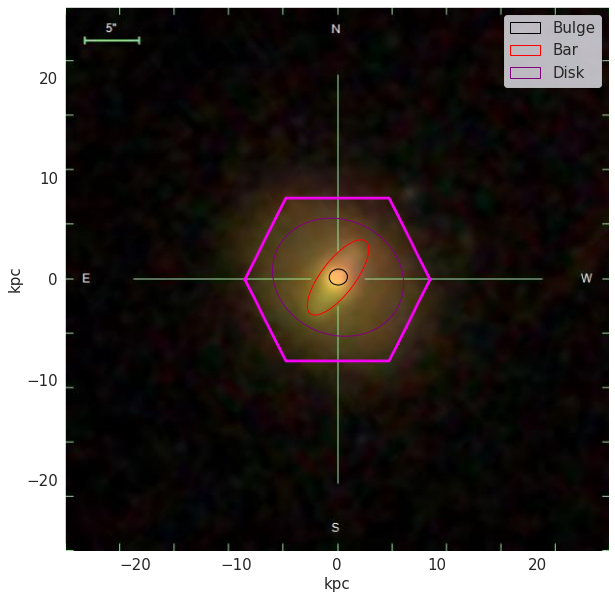

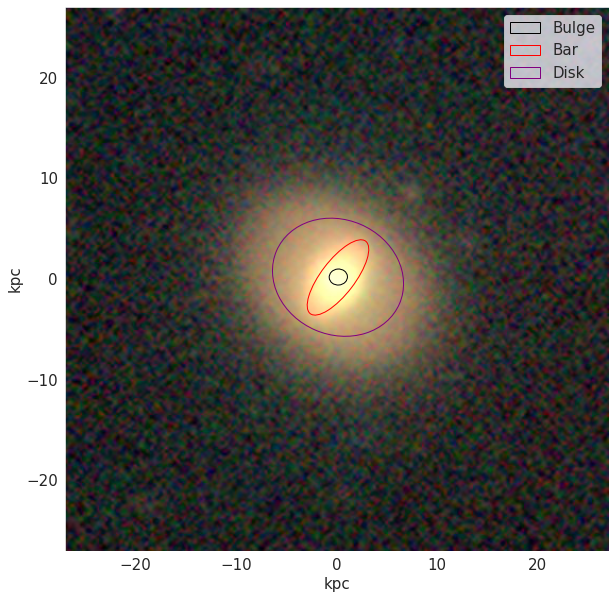

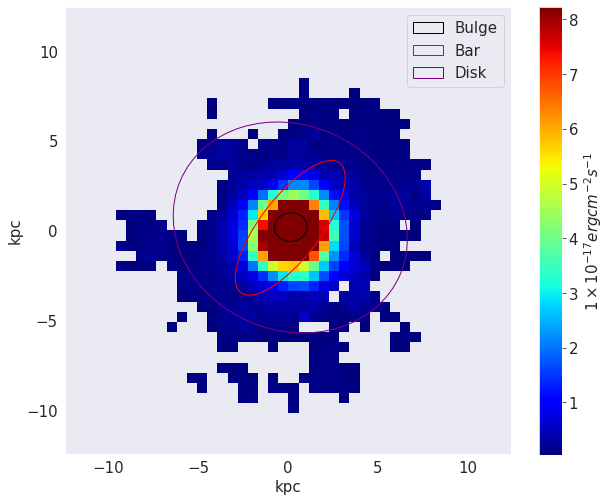

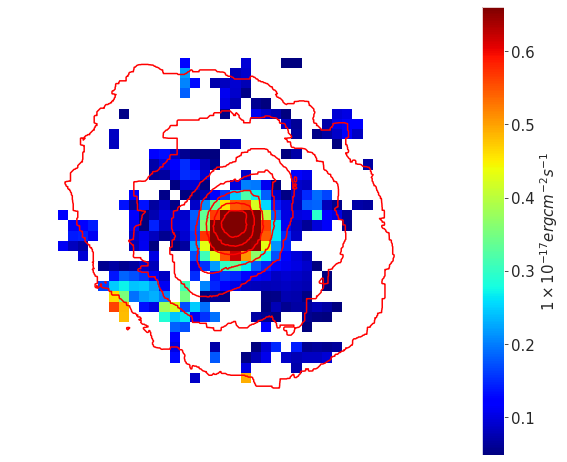

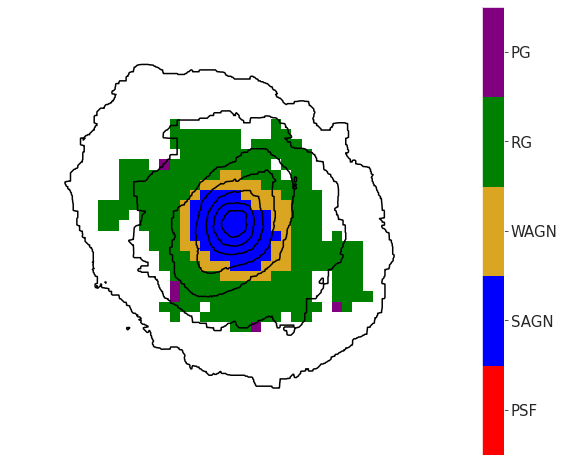

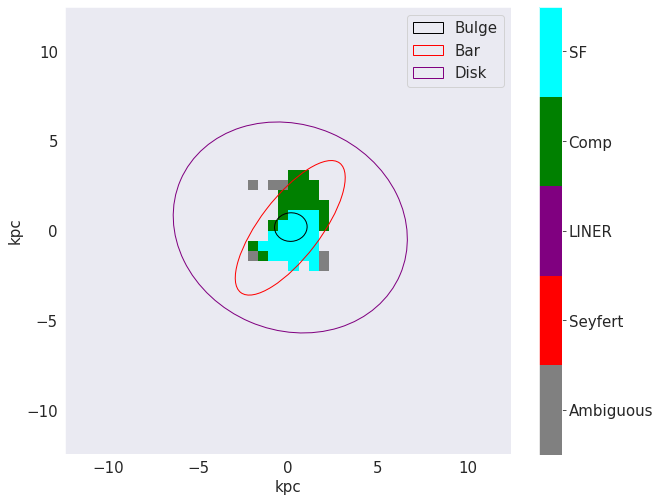

In [ ]:
download = 0
format   = 'png'
colors_ = ['black','red','purple']
models = ['Bulge','Bar','Disk']
for plateifu in sf_s0:

  
  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # GalFIT apertures
  with open(f'/content/Kugelblitz/data/{plateifu}.json', 'r') as fout:
    m = json.load(fout)

  mods = m[0]
  
  # Physical Scale
  c = 299792  # speed of light [km/s]
  H0 = 70  # [km s^-1 Mpc^-1]
  redshift = maps.dapall['z']
  D = c * redshift / H0  # approx. distance to galaxy [Mpc]
  dist_scale = 1 / 206265 * D * 1e3 
  d = size_s*dist_scale
  r = d/2  #kpc.
  
  # Optical Image
  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(optical.data, extent = (-r,r,-r,r))
  ax1.grid(False)

  apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
  
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
  ax1.legend()
  ax1.set_xlabel('kpc')
  ax1.set_ylabel('kpc')
  
  if download:
      fig.savefig(f'{plateifu}/SDSS_cutout',bbox_inches = 'tight',format=format)
  
  #------------------------------------------------------------------------------------------

  # Get DeCALS Image
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(img.image, extent = (-r,r,-r,r))
  ax1.grid(False)
  #ax1.annotate(f'manga {plateifu}',(512-512/3,512-512/20),weight='bold',family='serif',color = 'white')
  if download:
      fig.savefig(f'{plateifu}/legacy_cutout',bbox_inches = 'tight',format=format)
  
  
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
  ax1.legend()
  ax1.set_xlabel('kpc')
  ax1.set_ylabel('kpc')

    # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

# H-alpha with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( )
  ha = maps.emline_gflux_ha_6564

  d = size*dist_scale
  r = d/2

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet', extent = (-r,r,-r,r))
  ax3.grid(False)
  #ax3.set_autoscale_on(False)
  #ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax3,color = colors_[k], label = models[k])
  ax3.legend()
  ax3.set_xlabel('kpc')
  ax3.set_ylabel('kpc')

  if download:
      fig.savefig(f'{plateifu}/H_alpha',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # H-delta with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H delta Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.axis('off')

  if download:
      fig.savefig(f'{plateifu}/H_delta',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha=maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax2.grid(False)
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  #ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/WHAN',bbox_inches = 'tight',format=format)
  #------------------------------------------------------------------------------------------
  
  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot()
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  nocov = ewha.pixmask.get_mask('NOCOV')
  
  bpt[bpt==0]=np.nan
  
  #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5,extent = (-r,r,-r,r), origin = 'lower')
  #ax4.set_autoscale_on(False)
  #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])

  #ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

  if download:
      fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)
  
  for k, aperture in enumerate(apertures):
    apertures[aperture].plot(ax4,color = colors_[k], label = models[k])
  ax4.legend()
  ax4.set_xlabel('kpc')
  ax4.set_ylabel('kpc')
  break
  #------------------------------------------------------------------------------------------

  dn=maps.specindex_dn4000

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
  img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')

  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/DN4000',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824,label= '12+log(O/H)')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  #ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/Metallicity',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
  
  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")
  
  if download:
      fig.savefig(f'{plateifu}/SFRD',bbox_inches = 'tight',format = format)
  
  #------------------------------------------------------------------------------------------  
  
  # OIII/OII map
  OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')

  fig = plt.figure(figsize = (10,10))   
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)
  
  img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
  cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/OIII_OII',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------
      
    # H alpha EW
  ewha = maps['emline_sew_ha_6564']
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_alpha',bbox_inches = 'tight')
  
  #--------------------------------------------------------------------------------------------
    # H delta EW
  ewha = maps.emline_sew_hdel_4102
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H delta EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_delta',bbox_inches = 'tight')
      
  # OIII 5007 EW
  ewOIII = maps['emline_sew_oiii_5008']
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax3.grid(False)
  cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
  img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewOIII',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------
  break

Text(0, 0.5, 'kpc')

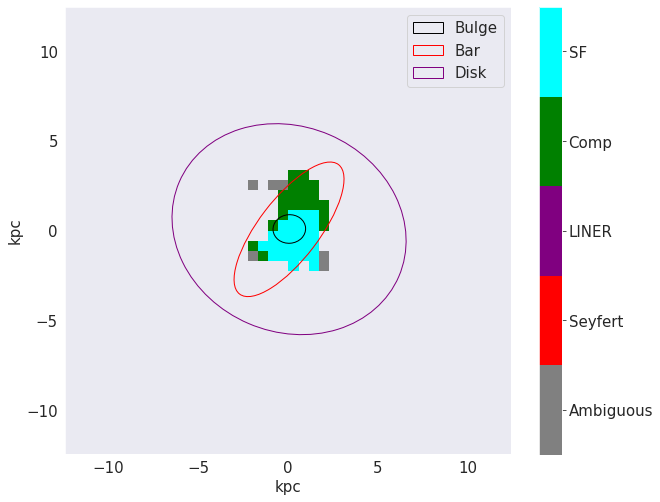

In [ ]:
fig = plt.figure(figsize = (10,10))
ax4 = fig.add_subplot()


SF = sf= m['sf']['global'].astype('float64')*5
COMP = m['comp']['global'].astype('float64')*4
LIN = m['liner']['global'].astype('float64')*3
SEY = m['seyfert']['global'].astype('float64')*2
AMB = m['ambiguous']['global'].astype('float64')*1

bpt = SF + COMP + LIN + SEY + AMB

cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
nocov = ewha.pixmask.get_mask('NOCOV')

bpt[bpt==0]=np.nan

#fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5,extent = (-r,r,-r,r), origin ='lower')
#ax4.set_autoscale_on(False)
#ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])

#ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

if download:
    fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)

for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax4,color = colors_[k], label = models[k])
ax4.legend()
ax4.set_xlabel('kpc')
ax4.set_ylabel('kpc')

In [ ]:
download = 0
format   = 'png'
for plateifu in dr16:

  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r = np.rot90(np.array(optical.data)[:,:,0].T )
  levels   = [60.,  90., 120., 150., 180., 210., 240.]
  ha       = maps.emline_gflux_ha_6564
  hb       = maps.emline_gflux_hb_4862
  ha_hb    = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  
  sf       = m['sf']['global'].astype('float64')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa   = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L  = cosmo.luminosity_distance(z).to(u.cm)
  Lha  =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR  = 5.5e-42*Lha
  SFR  = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb = plt.colorbar(img, ax = ax4, shrink = 0.8)
  cb.set_label(r'$Log_{10}(1/yr)$')

  ax4.annotate(r'sSFR Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

In [ ]:
cube.vacs.firefly['mastar'].data

FITS_rec([('1-295155', '9049-3704', 9049, '3704', 247.53065, 23.925957, 0.01481175, 9.227936, 'v3_1_1', 'v3_1_0', 'v1_0_1')],
         dtype=(numpy.record, [('MANGAID', 'S20'), ('PLATEIFU', 'S20'), ('PLATE', '>i2'), ('IFUDSGN', 'S20'), ('OBJRA', '>f4'), ('OBJDEC', '>f4'), ('REDSHIFT', '>f4'), ('PHOTOMETRIC_MASS', '>f4'), ('MANGADRP_ver', 'S20'), ('MANGADAP_ver', 'S20'), ('FIREFLY_ver', 'S20')]))

In [ ]:
fig  = plt.figure(figsize = (33,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1, 1.32,1.24], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()):
  
  img = plt.imread(f'{fil}/legacy_cutout')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/SDSS_cutout')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/BPT')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_alpha')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

In [ ]:
fig  = plt.figure(figsize = (35,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1.001, 0.97,1.], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()[3:-1]):
  
  img = plt.imread(f'{fil}/ewH_alpha.png')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_delta')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/DN4000')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/Metallicity')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

# **Maps 2.0**

In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  ax1 = fig.add_subplot(gs[i], projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(img.image)
  ax1.grid(False)
  ax1.annotate(f'manga {plateifu}',(512- len(plateifu)*23,482),weight='bold',family='serif',color = 'white')
  ax1.axis('off')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(optical.data)
  ax1.grid(False)
  optical.overlay_hexagon(ax1)
  ax1.axis('off')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(sf_s0):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_ha_6564

  ax.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax.imshow(np.log10(goodspax(ha)),cmap='jet')
  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11) 

  ax.coords[0].set_ticks([]*u.degree)
  ax.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_label(r'$Log_{10}(1\times10^{-17}ergcm^{-2}s^{-1})$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  
  bpt[bpt==0]=np.nan
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
  
cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ewha = maps['emline_sew_ha_6564']

  ax2 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  img = ax2.imshow((goodspax(ewha)),cmap = 'hsv')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax2.coords[0].set_ticks([]*u.degree)
  ax2.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax2)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_label(r'$\AA$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  hd = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  img = ax3.imshow(np.log10(goodspax(hd)),cmap='plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax3)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_label(r'$Log_{10}(1\times10^{-17}ergcm^{-2}s^{-1})$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  dn=maps.specindex_dn4000

  ax4.grid(False)
  img = ax4.imshow(goodspax(dn) ,cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  ha = maps.emline_gflux_ha_6564
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax3)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_label(r'12+log(O/H)')
plt.subplots_adjust(hspace = 0.01)


# **MaNGA Cube animation**

In [ ]:
maps = Maps(plateifu='9181-9101',mode='remote')

In [ ]:
cube = maps.getCube()

In [ ]:
flux = cube.flux
y    = flux.value
x    = flux.wavelength.value

In [ ]:
!mkdir images

In [ ]:
for i in range(220):
  fig = plt.figure(figsize = (25,8))
  gs = gridspec.GridSpec(1,2,width_ratios=[1,2]) 
  ax1 = fig.add_subplot(gs[0],projection = cube.wcs, slices = ('x','y',0))
  ax2 = fig.add_subplot(gs[1])
  im = ax1.imshow(y[i*20], cmap= 'jet')
  pl = ax2.plot(x,y.sum(axis=(1,2)), color ='purple')
  ax2.set_ylim(0,500)
  y_l = np.linspace(0,500,10)
  x_l = y_l*0 + x[i*20]
  ax2.plot(x_l,y_l, color ='black')
  ax2.set_ylabel(r'Flux [1x$10^{-17}]$ $ergs/s/cm^2$')
  ax2.set_xlabel('Wavelength [Å]')
  fig.savefig(f'images/img{i}.png')
  plt.close()

In [ ]:
!mkdir images

In [ ]:
writer = anim.FFMpegWriter(
    fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)